# South Asia Terrorism Analysis

---

### This notebook performs an exploratory data analysis (EDA) of terrorism incidents in South Asia, leveraging data from the Global Terrorism Database (GTD).

The analysis aims to uncover key trends, patterns, and characteristics of terrorist activities within the region, focusing on:
* **Temporal Trends:** How incidents and casualties have evolved over time.
* **Geographical Distribution:** Where incidents are most prevalent and their spatial patterns.
* **Attack Modalities:** The most common attack types and their associated casualty impacts.
* **Target Analysis:** Who are the most frequently targeted groups.

**Data Source:** Global Terrorism Database (GTD) - [You can add a link to the GTD here if you want, e.g., National Consortium for the Study of Terrorism and Responses to Terrorism (START)]

---

In [1]:
import pandas as pd
from scipy.stats import chi2_contingency
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs        # For map projections
import cartopy.feature as cfeature

## 1. Data Loading and Initial Inspection

In [2]:
#Load the Dataset
df=pd.read_csv('dataset/gt-dataset.csv',encoding='latin1')

C:\Users\HP\AppData\Local\Temp\ipykernel_36908\3998800215.py:2: DtypeWarning: Columns (4,6,31,33,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('dataset/gt-dataset.csv',encoding='latin1')


In [3]:
df.head()
df.info()
df.shape
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181691 entries, 0 to 181690
Columns: 135 entries, eventid to related
dtypes: float64(55), int64(22), object(58)
memory usage: 187.1+ MB


Index(['eventid', 'iyear', 'imonth', 'iday', 'approxdate', 'extended',
       'resolution', 'country', 'country_txt', 'region',
       ...
       'addnotes', 'scite1', 'scite2', 'scite3', 'dbsource', 'INT_LOG',
       'INT_IDEO', 'INT_MISC', 'INT_ANY', 'related'],
      dtype='object', length=135)

### 1.1 Data Cleaning and Preparation

In [4]:
print(df['region_txt'].unique())
print(df['country_txt'].unique())

['Central America & Caribbean' 'North America' 'Southeast Asia'
 'Western Europe' 'East Asia' 'South America' 'Eastern Europe'
 'Sub-Saharan Africa' 'Middle East & North Africa' 'Australasia & Oceania'
 'South Asia' 'Central Asia']
['Dominican Republic' 'Mexico' 'Philippines' 'Greece' 'Japan'
 'United States' 'Uruguay' 'Italy' 'East Germany (GDR)' 'Ethiopia'
 'Guatemala' 'Venezuela' 'West Germany (FRG)' 'Switzerland' 'Jordan'
 'Spain' 'Brazil' 'Egypt' 'Argentina' 'Lebanon' 'Ireland' 'Turkey'
 'Paraguay' 'Iran' 'United Kingdom' 'Colombia' 'Bolivia' 'Nicaragua'
 'Netherlands' 'Belgium' 'Canada' 'Australia' 'Pakistan' 'Zambia' 'Sweden'
 'Costa Rica' 'South Yemen' 'Cambodia' 'Israel' 'Poland' 'Taiwan' 'Panama'
 'Kuwait' 'West Bank and Gaza Strip' 'Austria' 'Czechoslovakia' 'India'
 'France' 'South Vietnam' 'Brunei' 'Zaire'
 "People's Republic of the Congo" 'Portugal' 'Algeria' 'El Salvador'
 'Thailand' 'Haiti' 'Sudan' 'Morocco' 'Cyprus' 'Myanmar' 'Afghanistan'
 'Peru' 'Chile' 'Honduras' 'Y

In [5]:
#Filter the DataFrame to include only the South Asia region.
#This ensures our analysis is focused on the specified geographical scope.
df_south_asia = df[df['region_txt'] == 'South Asia'].copy()
print(df_south_asia.shape)

(44974, 135)


In [6]:
df_south_asia['total_casualties'] = df_south_asia['nkill'].fillna(0) + df_south_asia['nwound'].fillna(0)

### 1.2 Geographical Data Characteristics

In [7]:
print("Unique Countries in South Asia:")
print(df_south_asia['country_txt'].unique())

print("\nNumber of Unique Provinces/States:")
print(df_south_asia['provstate'].nunique())
print(df_south_asia['provstate'].value_counts().head(10)) # Top 10 provinces/states

print("\nNumber of Unique Cities:")
print(df_south_asia['city'].nunique())
print(df_south_asia['city'].value_counts().head(10)) # Top 10 cities

print("\nSummary Statistics for Latitude:")
print(df_south_asia['latitude'].describe())

print("\nSummary Statistics for Longitude:")
print(df_south_asia['longitude'].describe())

print("\nPercentage of Missing Latitude/Longitude:")
print(f"{df_south_asia['latitude'].isnull().sum() / len(df_south_asia) * 100:.2f}% missing latitude")
print(f"{df_south_asia['longitude'].isnull().sum() / len(df_south_asia) * 100:.2f}% missing longitude")

Unique Countries in South Asia:
['Pakistan' 'India' 'Afghanistan' 'Sri Lanka' 'Bangladesh' 'Nepal'
 'Maldives' 'Mauritius' 'Bhutan']

Number of Unique Provinces/States:
117
provstate
Balochistan                            3710
Sindh                                  3206
Khyber Pakhtunkhwa                     3084
Jammu and Kashmir                      2454
Federally Administered Tribal Areas    2392
Punjab                                 1778
Helmand                                1234
Eastern                                1169
Assam                                  1151
Kandahar                               1122
Name: count, dtype: int64

Number of Unique Cities:
11412
city
Karachi     2651
Unknown     2038
Peshawar     819
Quetta       803
Kabul        738
Srinagar     658
Dhaka        557
Imphal       426
Kandahar     363
Colombo      323
Name: count, dtype: int64

Summary Statistics for Latitude:
count    44479.000000
mean        28.431264
std          7.329244
min        -20.420

## 2. Exploratory Data Analysis (EDA)

### 2.1 Geographical Distribution of Incidents

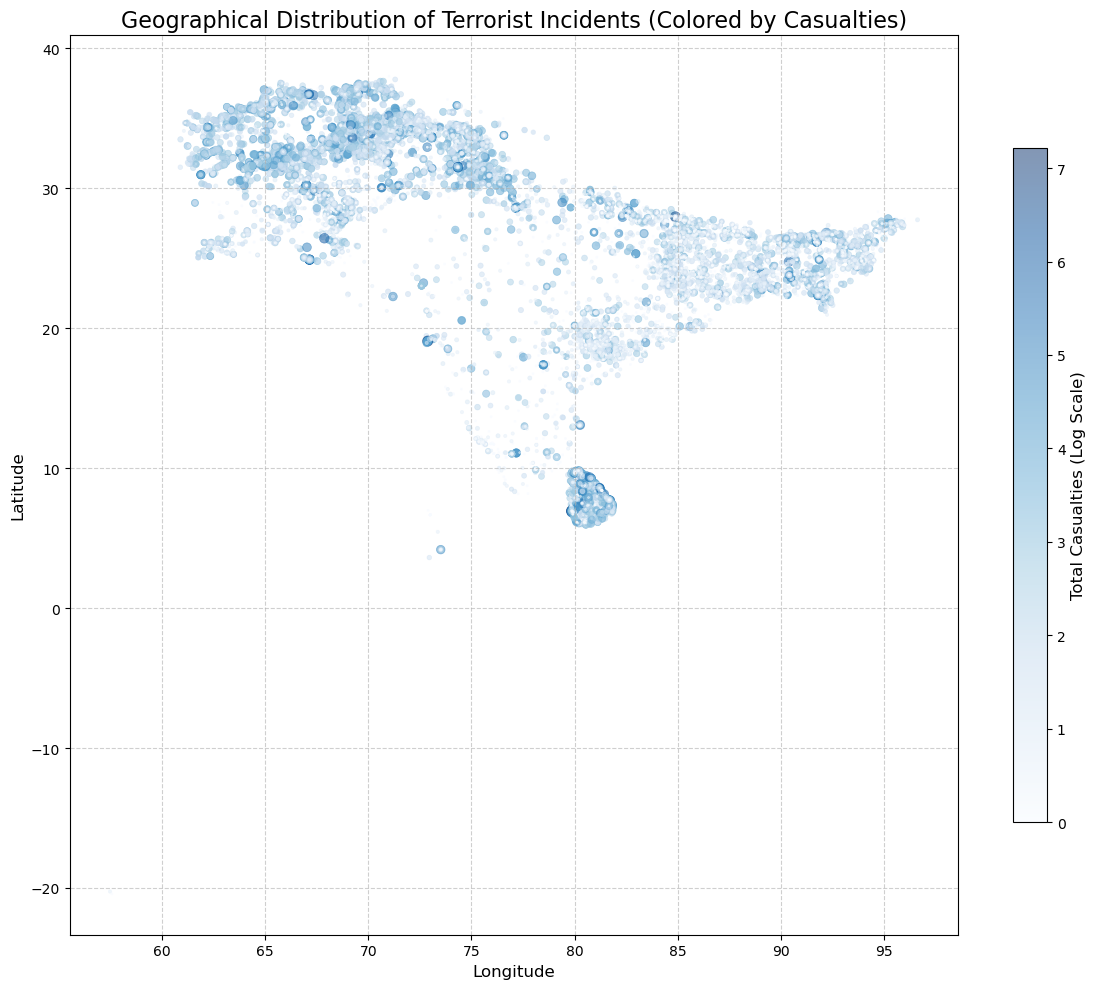

In [8]:
# plt.figure(figsize=(10, 10))
# plt.scatter(df_south_asia['longitude'], df_south_asia['latitude'], s=5, alpha=0.5)
# plt.title('Geographical Distribution of Terrorist Attacks in South Asia')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.grid(True)
# plt.show()

plt.figure(figsize=(12, 10)) # Adjust figure size

# Prepare data for coloring and sizing (log scale for better visual distinction)
# Handle potential zero casualties for log scaling gracefully.
df_south_asia['total_casualties_log'] = np.log1p(df_south_asia['total_casualties']) # log(1+x) handles zeros
# Define marker sizes based on casualties, ensure a visible min size
# Adjust the multiplier (e.g., 5, 10, 20) to make points more visible if needed
df_south_asia['marker_size'] = np.where(df_south_asia['total_casualties'] > 0, df_south_asia['total_casualties_log'] * 8, 2)


scatter = plt.scatter(
    df_south_asia['longitude'],
    df_south_asia['latitude'],
    c=df_south_asia['total_casualties_log'], # Color by log-transformed casualties
    s=df_south_asia['marker_size'],         # Size by log-transformed casualties
    cmap='Blues',                             # Colormap (e.g., 'Reds', 'viridis', 'YlOrRd')
    alpha=0.5 ,                              # Transparency for density,                       # Add small black outline to points
    linewidth=0.5
)

# Add a colorbar to explain the color scale
cbar = plt.colorbar(scatter, orientation='vertical', shrink=0.75, pad=0.05)
cbar.set_label('Total Casualties (Log Scale)', fontsize=12)

plt.title('Geographical Distribution of Terrorist Incidents (Colored by Casualties)', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6) # Add a grid for better readability
plt.tight_layout()
plt.show()

### 2.2  Geographical Hotspots (Top Locations)

In [9]:
print("Top Countries by Attack Count:")
print(df_south_asia['country_txt'].value_counts().head(5))

print("\nTop Provinces/States by Attack Count:")
print(df_south_asia['provstate'].value_counts().head(5))

print("\nTop Cities by Attack Count:")
print(df_south_asia['city'].value_counts().head(5))

Top Countries by Attack Count:
country_txt
Pakistan       14368
Afghanistan    12731
India          11960
Sri Lanka       3022
Bangladesh      1648
Name: count, dtype: int64

Top Provinces/States by Attack Count:
provstate
Balochistan                            3710
Sindh                                  3206
Khyber Pakhtunkhwa                     3084
Jammu and Kashmir                      2454
Federally Administered Tribal Areas    2392
Name: count, dtype: int64

Top Cities by Attack Count:
city
Karachi     2651
Unknown     2038
Peshawar     819
Quetta       803
Kabul        738
Name: count, dtype: int64


### 2.3 Attack Type Analysis


In [10]:
print("Unique Attack Types and their counts:")
print(df_south_asia['attacktype1_txt'].value_counts())

Unique Attack Types and their counts:
attacktype1_txt
Bombing/Explosion                      21246
Armed Assault                          11404
Assassination                           4301
Hostage Taking (Kidnapping)             3277
Facility/Infrastructure Attack          2189
Unknown                                 2021
Unarmed Assault                          323
Hostage Taking (Barricade Incident)      120
Hijacking                                 93
Name: count, dtype: int64


Top 5 Attack Types: ['Bombing/Explosion', 'Armed Assault', 'Assassination', 'Hostage Taking (Kidnapping)', 'Facility/Infrastructure Attack']


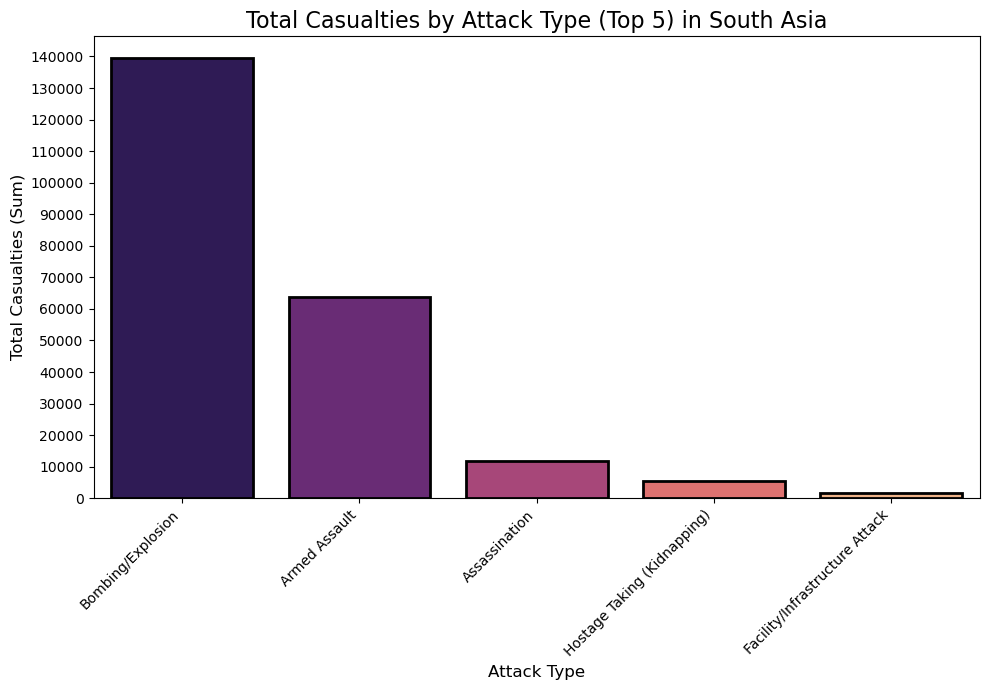

In [11]:
# Get the top 5 attack types by their incident count
top_attack_types = df_south_asia['attacktype1_txt'].value_counts().nlargest(5).index.tolist()
print("Top 5 Attack Types:", top_attack_types)

# --- Calculate Total Casualties for each top attack type ---
total_casualties_df = df_south_asia[
    df_south_asia['attacktype1_txt'].isin(top_attack_types)
].groupby('attacktype1_txt')['total_casualties'].sum().reset_index()

# Sort the results by total casualties for a clearer bar chart (highest to lowest)
total_casualties_df = total_casualties_df.sort_values(by='total_casualties', ascending=False)

# --- Plot a Simple Bar Chart of Total Casualties ---
plt.figure(figsize=(10, 7)) # Adjusted figure size

sns.barplot(
    x='attacktype1_txt',    
    y='total_casualties',   
    data=total_casualties_df,
    palette='magma',        
    edgecolor='black',      
    linewidth=2.0             
)

# You might still need a log scale here if the sums vary wildly, but let's try linear first
# plt.yscale('log')
# plt.yticks([1, 10, 100, 1000, 10000, 100000], ['1', '10', '100', '1K', '10K', '100K'])

plt.title('Total Casualties by Attack Type (Top 5) in South Asia', fontsize=16)
plt.xlabel('Attack Type', fontsize=12)
plt.ylabel('Total Casualties (Sum)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(np.arange(0, total_casualties_df['total_casualties'].max() + 10000, 10000), fontsize=10)
plt.tight_layout()
plt.show()

### 2.4 Target Type Analysis

In [12]:
print("\nUnique Target Types and their counts:")
print(df_south_asia['targtype1_txt'].value_counts())


Unique Target Types and their counts:
targtype1_txt
Private Citizens & Property       10491
Police                             8471
Military                           5696
Government (General)               5463
Business                           3123
Unknown                            2402
Transportation                     2112
Educational Institution            1781
Religious Figures/Institutions     1141
Violent Political Party            1106
Utilities                           799
Terrorists/Non-State Militia        697
Journalists & Media                 438
Telecommunication                   303
Government (Diplomatic)             302
NGO                                 296
Airports & Aircraft                 174
Food or Water Supply                 63
Tourists                             50
Maritime                             49
Other                                17
Name: count, dtype: int64


### 2.5 Overall Tactic-Target Relationships

 #### 2.5.1 Relationship Between Attack Types and Target Types

In [13]:
# Contingency Table for Attack Type vs. Target Type
# This helps identify common pairings of 'how' an attack is carried out and 'who' is targeted.
tactic_target_crosstab = pd.crosstab(df_south_asia['attacktype1_txt'], df_south_asia['targtype1_txt'])
print(tactic_target_crosstab)

targtype1_txt                        Airports & Aircraft  Business  \
attacktype1_txt                                                      
Armed Assault                                         12       541   
Assassination                                          3       109   
Bombing/Explosion                                    118      1541   
Facility/Infrastructure Attack                         7       477   
Hijacking                                             20        10   
Hostage Taking (Barricade Incident)                    1        33   
Hostage Taking (Kidnapping)                            3       342   
Unarmed Assault                                        0        24   
Unknown                                               10        46   

targtype1_txt                        Educational Institution  \
attacktype1_txt                                                
Armed Assault                                            213   
Assassination                        

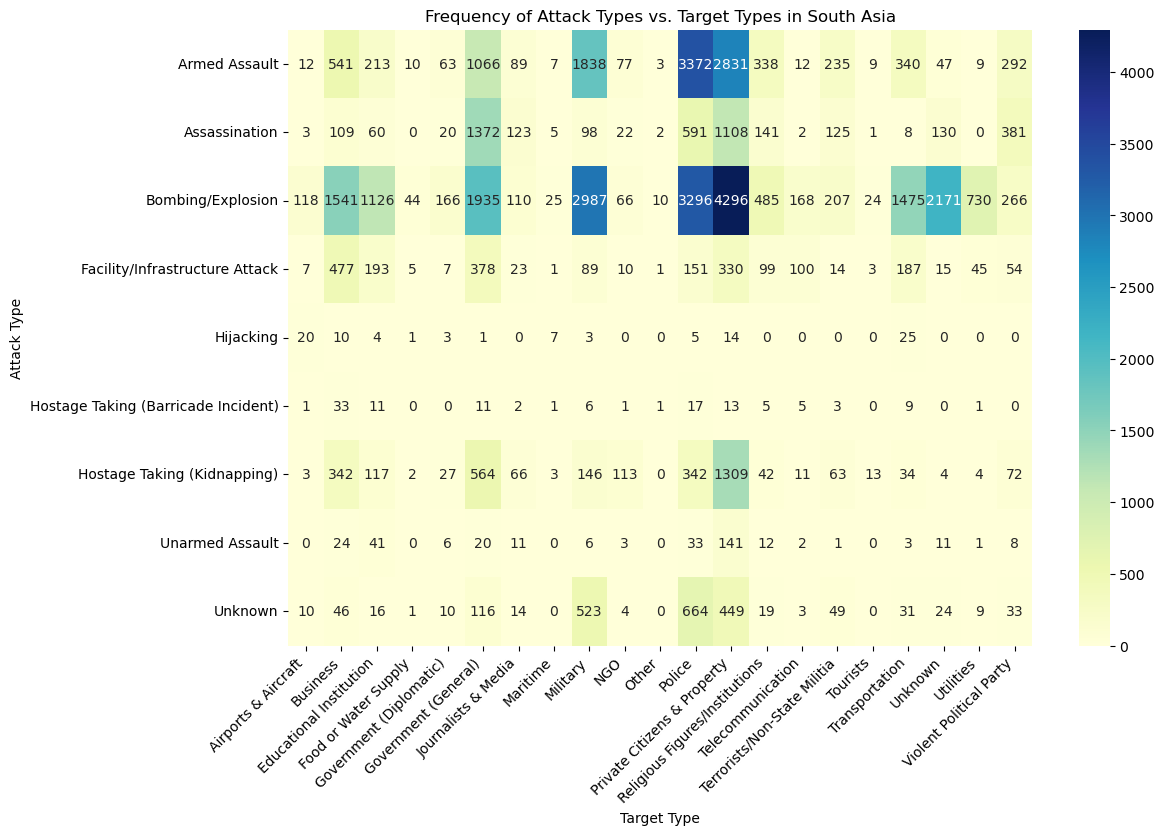

In [14]:
# Heatmap Visualization
plt.figure(figsize=(12, 8))
sns.heatmap(tactic_target_crosstab, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Frequency of Attack Types vs. Target Types in South Asia")
plt.xlabel("Target Type")
plt.xticks(rotation=45,ha='right', fontsize=10)
plt.ylabel("Attack Type")
plt.show()

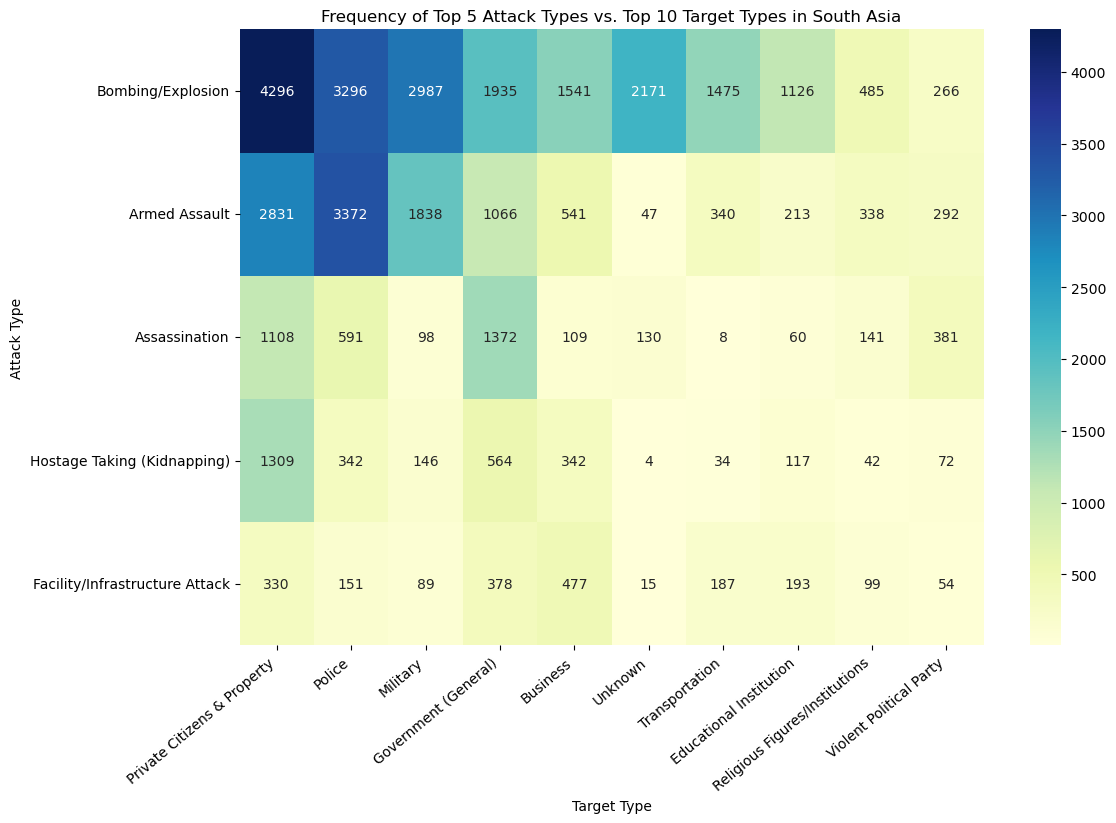

In [15]:
top_n_attacks = 5
top_n_targets = 10

top_attack_types = df_south_asia['attacktype1_txt'].value_counts().nlargest(top_n_attacks).index
top_target_types = df_south_asia['targtype1_txt'].value_counts().nlargest(top_n_targets).index

top_tactic_target_crosstab = tactic_target_crosstab.loc[top_attack_types, top_target_types]

plt.figure(figsize=(12, 8))
sns.heatmap(top_tactic_target_crosstab, annot=True, fmt="d", cmap="YlGnBu", linewidths=0)
plt.title(f"Frequency of Top {top_n_attacks} Attack Types vs. Top {top_n_targets} Target Types in South Asia")
plt.xlabel("Target Type")
plt.xticks(rotation=40, ha='right', fontsize=10)
plt.ylabel("Attack Type")
plt.show()

#### Observations from Top Attack Type vs. Top Target Type Heatmap:

* The most prevalent pairing is **'Bombing/Explosion' against 'Private Citizens & Property' (4296 incidents)**, highlighting its widespread use against civilians.
* **'Bombing/Explosion'** is consistently a high-frequency method across diverse targets including Police, Military, and Government (General).
* **'Armed Assaults'** are also very common, notably against Police (3372) and Private Citizens & Property (2831).
* **'Assassinations'** show a distinct focus on 'Government (General)' (1372) and 'Private Citizens & Property' (1108).
* **'Hostage Taking (Kidnapping)'** primarily targets 'Private Citizens & Property' (1309) and 'Government (General)' (564).
* This heatmap effectively illustrates the dominant tactical preferences and their most frequent targets in South Asia.

#### 2.5.2 Average Casualties by Attack Type vs. Target Type
Next, we examine the average total casualties for these top attack and target type pairings, offering insights into the impact of each combination.

In [16]:
avg_casualties = df_south_asia.groupby(['attacktype1_txt', 'targtype1_txt'])['total_casualties'].mean().unstack(fill_value=0)
print(avg_casualties)

targtype1_txt                        Airports & Aircraft   Business  \
attacktype1_txt                                                       
Armed Assault                                   5.916667   3.940850   
Assassination                                   1.333333   1.449541   
Bombing/Explosion                               3.898305   7.757949   
Facility/Infrastructure Attack                  0.142857   0.207547   
Hijacking                                       8.900000   0.800000   
Hostage Taking (Barricade Incident)             3.000000  13.878788   
Hostage Taking (Kidnapping)                     1.000000   0.616959   
Unarmed Assault                                 0.000000   1.791667   
Unknown                                         0.100000   5.326087   

targtype1_txt                        Educational Institution  \
attacktype1_txt                                                
Armed Assault                                       3.037559   
Assassination             

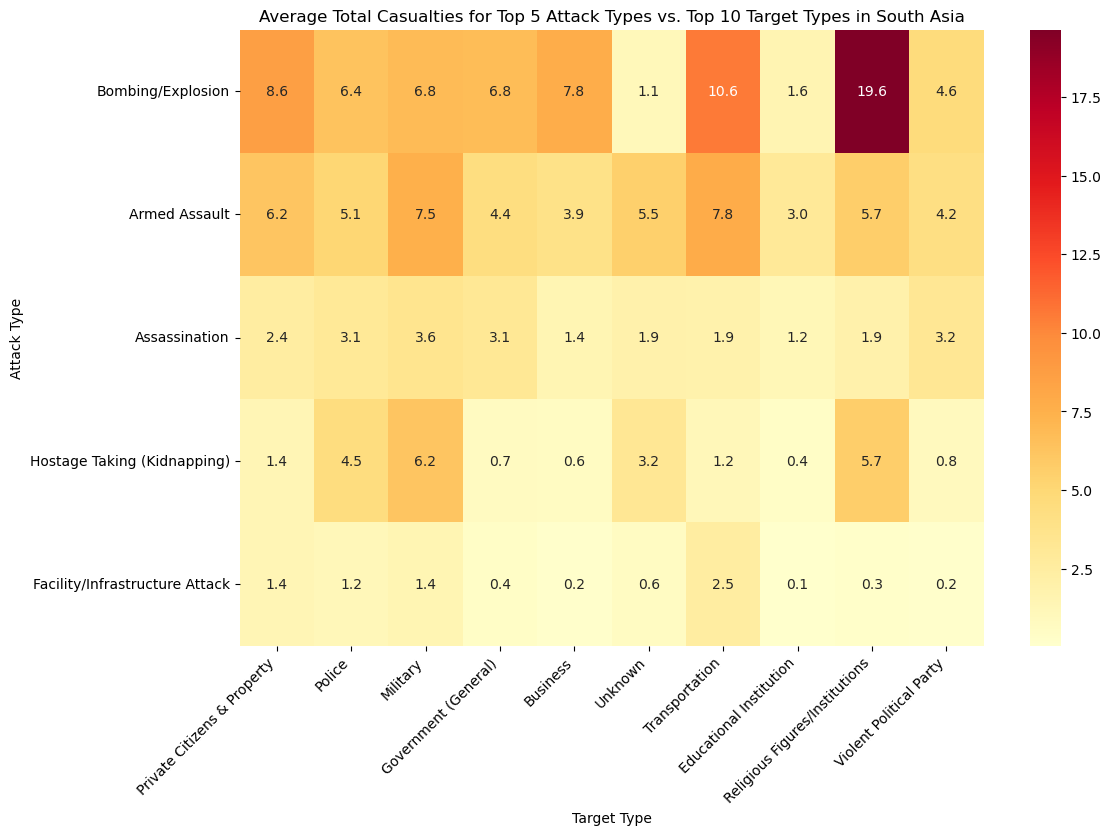

In [17]:
top_n_attacks = 5
top_n_targets = 10

top_attack_types = df_south_asia['attacktype1_txt'].value_counts().nlargest(top_n_attacks).index
top_target_types = df_south_asia['targtype1_txt'].value_counts().nlargest(top_n_targets).index

avg_casualties_top = avg_casualties.loc[top_attack_types, top_target_types]

plt.figure(figsize=(12, 8))
sns.heatmap(avg_casualties_top, annot=True, fmt=".1f", cmap="YlOrRd")
plt.title(f"Average Total Casualties for Top {top_n_attacks} Attack Types vs. Top {top_n_targets} Target Types in South Asia")
plt.xlabel("Target Type")
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylabel("Attack Type")
plt.show()

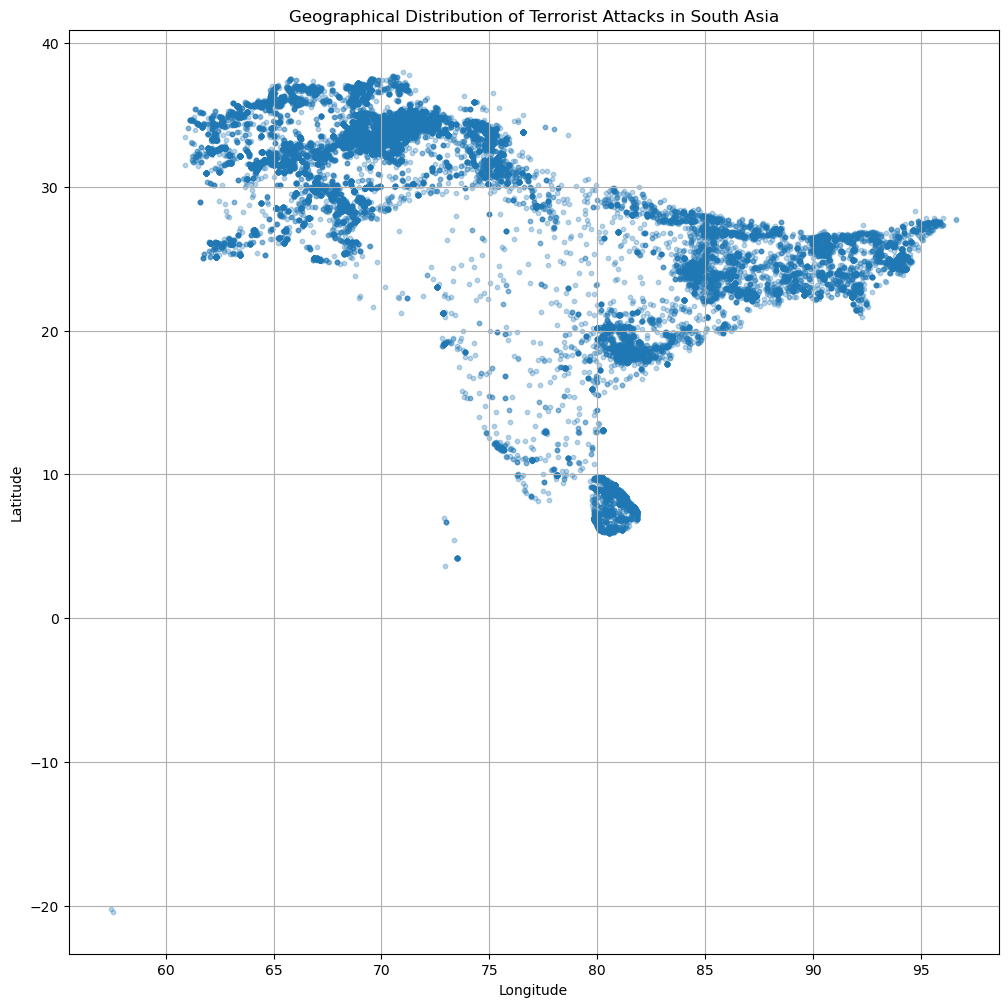

In [18]:
plt.figure(figsize=(12, 12))
plt.scatter(df_south_asia['longitude'], df_south_asia['latitude'], s=10, alpha=0.3)
plt.title('Geographical Distribution of Terrorist Attacks in South Asia')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

In [19]:
print("Top Countries by Attack Count:")
print(df_south_asia['country_txt'].value_counts().head(5))

print("\nTop Provinces/States by Attack Count:")
print(df_south_asia['provstate'].value_counts().head(5))

print("\nTop Cities by Attack Count:")
print(df_south_asia['city'].value_counts().head(5))

Top Countries by Attack Count:
country_txt
Pakistan       14368
Afghanistan    12731
India          11960
Sri Lanka       3022
Bangladesh      1648
Name: count, dtype: int64

Top Provinces/States by Attack Count:
provstate
Balochistan                            3710
Sindh                                  3206
Khyber Pakhtunkhwa                     3084
Jammu and Kashmir                      2454
Federally Administered Tribal Areas    2392
Name: count, dtype: int64

Top Cities by Attack Count:
city
Karachi     2651
Unknown     2038
Peshawar     819
Quetta       803
Kabul        738
Name: count, dtype: int64


### 2.6 Terrorist Group Analysis

In [20]:
# Calculate the top 15 most active terrorist groups in South Asia, excluding 'Unknown' groups.
# This focuses the analysis on identifiable perpetrators.
print("Top 15 Most Active Terrorist Groups in South Asia (Excluding Unknown):")
top_groups = df_south_asia[df_south_asia['gname']!='Unknown']['gname'].value_counts().nlargest(15)
print(top_groups)

# Convert top_groups Series index to a list for filtering
top_group_names = top_groups.index.tolist()

Top 15 Most Active Terrorist Groups in South Asia (Excluding Unknown):
gname
Taliban                                           7477
Communist Party of India - Maoist (CPI-Maoist)    1878
Maoists                                           1625
Liberation Tigers of Tamil Eelam (LTTE)           1604
Tehrik-i-Taliban Pakistan (TTP)                   1350
Sikh Extremists                                    712
People's Liberation Front (JVP)                    433
United Liberation Front of Assam (ULFA)            357
Khorasan Chapter of the Islamic State              343
Baloch Republican Army (BRA)                       312
Tamils                                             217
Hizbul Mujahideen (HM)                             199
Lashkar-e-Taiba (LeT)                              190
Baloch Liberation Front (BLF)                      185
Baloch Liberation Army (BLA)                       181
Name: count, dtype: int64



Average Total Casualties per Top Terrorist Group:
gname
Lashkar-e-Taiba (LeT)                             15.705263
Khorasan Chapter of the Islamic State             14.466472
Liberation Tigers of Tamil Eelam (LTTE)           13.728180
Tehrik-i-Taliban Pakistan (TTP)                   11.536296
Tamils                                            11.110599
United Liberation Front of Assam (ULFA)            7.764706
Taliban                                            7.668450
Sikh Extremists                                    6.498596
Hizbul Mujahideen (HM)                             5.678392
Baloch Liberation Army (BLA)                       4.563536
People's Liberation Front (JVP)                    4.244804
Baloch Liberation Front (BLF)                      2.610811
Baloch Republican Army (BRA)                       2.567308
Communist Party of India - Maoist (CPI-Maoist)     2.134718
Maoists                                            1.849846
Name: total_casualties, dtype: float64


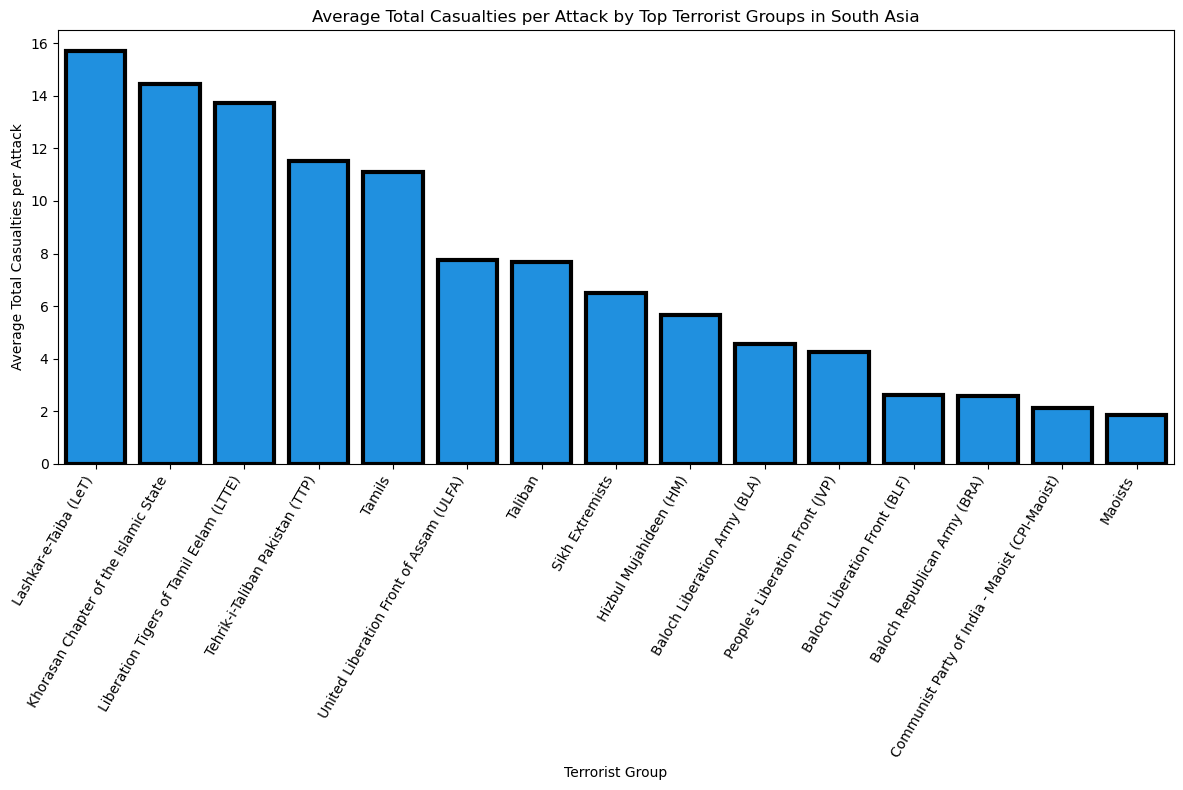

In [21]:
df_filtered_groups_for_casualties = df_south_asia[df_south_asia['gname'].isin(top_group_names)].copy()

# Calculate the mean total casualties for each top group
avg_casualties_per_group = df_filtered_groups_for_casualties.groupby('gname')['total_casualties'].mean().sort_values(ascending=False)

print("\nAverage Total Casualties per Top Terrorist Group:")
print(avg_casualties_per_group)
# Visualize the average total casualties per group using a bar chart.
plt.figure(figsize=(12, 8))
sns.barplot(x=avg_casualties_per_group.index, y=avg_casualties_per_group.values,
           color='#0096FF', edgecolor='black',      
            linewidth=3.0 )
plt.title('Average Total Casualties per Attack by Top Terrorist Groups in South Asia')
plt.xlabel('Terrorist Group')
plt.ylabel('Average Total Casualties per Attack')
plt.xticks(rotation=60, ha='right') # Rotate group names for readability
plt.tight_layout()
plt.show()

### 2.7 Group Specific Tactic Preferences

In [22]:
df_filtered_groups = df_south_asia[df_south_asia['gname'].isin(top_group_names)].copy()

# Cross-tabulation: Group vs. Attack Types (counts)
group_tactic_crosstab = pd.crosstab(df_filtered_groups['gname'], df_filtered_groups['attacktype1_txt'])

print("\nContingency Table (Top Groups vs. Attack Types):")
print(group_tactic_crosstab)

# Heatmap Visualization
group_tactic_proportions = group_tactic_crosstab.div(group_tactic_crosstab.sum(axis=1), axis=0) * 100

plt.figure(figsize=(14, 10)) # Adjust figure size for readability
sns.heatmap(group_tactic_proportions, annot=True, fmt=".1f", cmap="GnBu", linewidths=.5, linecolor='black')
plt.title('Preferred Attack Tactics (%) for Top Terrorist Groups in South Asia',fontsize=16)
plt.xlabel('Attack Type',fontsize=16)
plt.ylabel('Terrorist Group',fontsize=16)
plt.xticks(rotation=45, ha='right',fontsize=12) # Rotate x-axis labels for better readability
plt.yticks(rotation=0,fontsize=12) # Ensure y-axis labels are horizontal
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

NameError: name 'group_tactic_crosstab' is not defined

### 2.8 Group- Specific Target Preferences

In [ ]:
top_groups = df_south_asia[df_south_asia['gname'] != 'Unknown']['gname'].value_counts().nlargest(15)
top_group_names = top_groups.index.tolist()

# Filter the DataFrame to include only the top groups
df_filtered_groups_for_target = df_south_asia[df_south_asia['gname'].isin(top_group_names)].copy()

# Create the cross-tabulation
group_target_crosstab = pd.crosstab(df_filtered_groups_for_target['gname'], df_filtered_groups_for_target['targtype1_txt'])

print("Contingency Table (Top Groups vs. Target Types):")
print(group_target_crosstab)

In [ ]:
group_target_proportions = group_target_crosstab.div(group_target_crosstab.sum(axis=1), axis=0) * 100

my_custom_colors =['#FFC0CB',  '#F08080',  '#CD5C5C',  '#DC143C',  '#A50000']
plt.figure(figsize=(16, 12)) # Increased figure size for more target types
ax=sns.heatmap(group_target_proportions, annot=True, fmt=".1f", cmap=my_custom_colors, linewidths=.5, linecolor='#6B0000')

# --- Add a thick border around the entire plot using the 'ax' object ---
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_edgecolor('black') # Or any color like 'darkgrey', '#404040', etc.
    spine.set_linewidth(2.0) 
plt.title('Preferred Target Types (%) for Top Terrorist Groups in South Asia',fontsize=18)
plt.xlabel('Target Type',fontsize=16)
plt.ylabel('Terrorist Group',fontsize=16)
plt.xticks(rotation=45, ha='right',fontsize=12) # Rotate x-axis labels for better readability
plt.yticks(rotation=0,fontsize=12) # Ensure y-axis labels are horizontal


    
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

## 3. Statistical Analysis / Hypothesis Testing

### 3.1 Association between Terrorist Groups and Attack Types

In [ ]:
# Code Cell: Group vs. Attack Tactics - Chi-Squared Test
# Perform the Chi-Squared Test of Independence to assess if there's a statistically significant association 
# between terrorist groups and the attack types they choose.
chi2, p, dof, expected = chi2_contingency(group_tactic_crosstab)

print("\nChi-Squared Statistic (Top Groups vs. Attack Types):", chi2)
print("P-value (Top Groups vs. Attack Types):", p)
print("Degrees of Freedom:", dof)


### Interpretation:

### 3.2 Association between Terrorist Groups and Target Types

In [ ]:
chi2, p, dof, expected = chi2_contingency(group_target_crosstab)

print("\nChi-Squared Statistic (Top Groups vs. Target Types):", chi2)
print("P-value (Top Groups vs. Target Types):", p)
print("Degrees of Freedom:", dof)

In [ ]:
# Group Lethality Analysis - Average Casualties
# This metric quantifies the lethality or impact of each group's operations.
df_filtered_groups_for_casualties = df_south_asia[df_south_asia['gname'].isin(top_group_names)].copy()

# Calculate the mean total casualties for each top group
avg_casualties_per_group = df_filtered_groups_for_casualties.groupby('gname')['total_casualties'].mean().sort_values(ascending=False)

print("\nAverage Total Casualties per Top Terrorist Group:")
print(avg_casualties_per_group)